# Spectral Reconstruction: Comparison

In [1]:
import json
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import spectral as spy

from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('bgr', ['#494ca0', '#72bf75', '#9a4545'])

## Metrics

In [2]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2, axis=1))

def mrae(y_true, y_pred, epsilon=1e-3):
    return np.mean(np.abs(y_true - y_pred) / (y_true + epsilon), axis=1)

## Dataset

In [3]:
height, width, depth = 512, 508, 31
bands = np.arange(400, 700 + 1, 10)

In [4]:
with open('resources/CAVE.json', 'r') as file:
    images_test = [Path(f'datasets/CAVE/{it}.hdr') for it in json.load(file)['test']]

In [5]:
def load(path: Path):
    envi = spy.io.envi.open(path)
    y = envi.load()
    y = y.reshape(-1, y.shape[-1])

    X = np.load(path.with_suffix('.npy'))
    X = X.reshape(-1, X.shape[-1])
    return X, y

In [6]:
def load_dataset(images: list[Path]):
    Xs, ys = [], []

    for path in images:
        X, y = load(path)
        Xs.append(X)
        ys.append(y)

    return np.vstack(Xs), np.vstack(ys)

## Model Initialization

In [7]:
with open('models/CAVE_LR.pkl', 'rb') as file:
    model_lr = pickle.load(file)

In [8]:
with open('models/CAVE_PR.pkl', 'rb') as file:
    model_pr = pickle.load(file)

In [9]:
with open('models/CAVE_RELS.pkl', 'rb') as file:
    model_rels = pickle.load(file)

## Reconstructed Spectra

In [10]:
X_test, y_test = load(images_test[1])

In [11]:
X_test_poly = PolynomialFeatures(degree=6, include_bias=False).fit_transform(X_test)

In [12]:
y_pred_lr = model_lr.predict(X_test)

In [13]:
y_pred_pr = model_pr.predict(X_test)

In [14]:
y_pred_rels = model_rels.predict(X_test_poly)

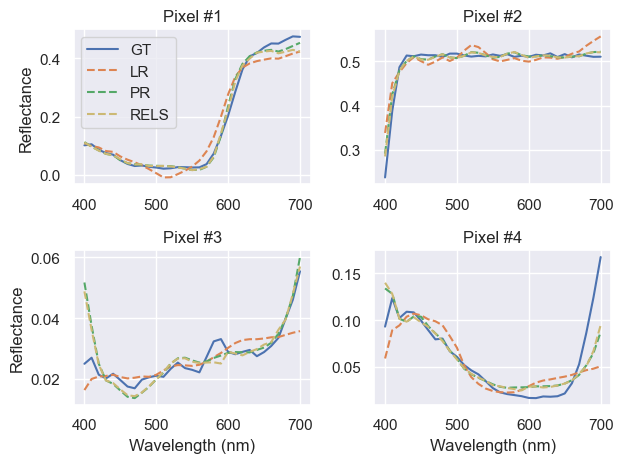

In [15]:
_, axes = plt.subplots(nrows=2, ncols=2)

axes[0, 0].set_title('Pixel #1')
axes[0, 0].plot(bands, y_test[197 * width + 324], label='GT')
axes[0, 0].plot(bands, y_pred_lr[197 * width + 324], linestyle='--', label='LR')
axes[0, 0].plot(bands, y_pred_pr[197 * width + 324], linestyle='--', label='PR')
axes[0, 0].plot(bands, y_pred_rels[197 * width + 324], linestyle='--', label='RELS', color='y')
axes[0, 0].set_ylabel('Reflectance')
axes[0, 0].legend()

axes[0, 1].set_title('Pixel #2')
axes[0, 1].plot(bands, y_test[153 * width + 485], label='GT')
axes[0, 1].plot(bands, y_pred_lr[153 * width + 485], linestyle='--', label='LR')
axes[0, 1].plot(bands, y_pred_pr[153 * width + 485], linestyle='--', label='PR')
axes[0, 1].plot(bands, y_pred_rels[153 * width + 485], linestyle='--', label='RELS', color='y')

axes[1, 0].set_title('Pixel #3')
axes[1, 0].plot(bands, y_test[288 * width + 164], label='GT')
axes[1, 0].plot(bands, y_pred_lr[288 * width + 164], linestyle='--', label='LR')
axes[1, 0].plot(bands, y_pred_pr[288 * width + 164], linestyle='--', label='PR')
axes[1, 0].plot(bands, y_pred_rels[288 * width + 164], linestyle='--', label='RELS', color='y')
axes[1, 0].set_xlabel('Wavelength (nm)')
axes[1, 0].set_ylabel('Reflectance')

axes[1, 1].set_title('Pixel #4')
axes[1, 1].plot(bands, y_test[400 * width + 355], label='GT')
axes[1, 1].plot(bands, y_pred_lr[400 * width + 355], linestyle='--', label='LR')
axes[1, 1].plot(bands, y_pred_pr[400 * width + 355], linestyle='--', label='PR')
axes[1, 1].plot(bands, y_pred_rels[400 * width + 355], linestyle='--', label='RELS', color='y')
axes[1, 1].set_xlabel('Wavelength (nm)')

plt.tight_layout()
plt.show()

## Heatmaps

In [16]:
rmse_lr = rmse(y_test, y_pred_lr).reshape(height, width)
mrae_lr = mrae(y_test, y_pred_lr).reshape(height, width)

In [17]:
rmse_pr = rmse(y_test, y_pred_pr).reshape(height, width)
mrae_pr = mrae(y_test, y_pred_pr).reshape(height, width)

In [18]:
rmse_rels = rmse(y_test, y_pred_rels).reshape(height, width)
mrae_rels = mrae(y_test, y_pred_rels).reshape(height, width)

In [19]:
rmse_costs = [rmse_lr, rmse_pr, rmse_rels]
rmse_vmin = min(cost.min() for cost in rmse_costs)
rmse_vmax = max(cost.max() for cost in rmse_costs)

In [20]:
mrae_costs = [mrae_lr, mrae_pr, mrae_rels]
mrae_vmin = min(cost.min() for cost in mrae_costs)
mrae_vmax = max(cost.max() for cost in mrae_costs)

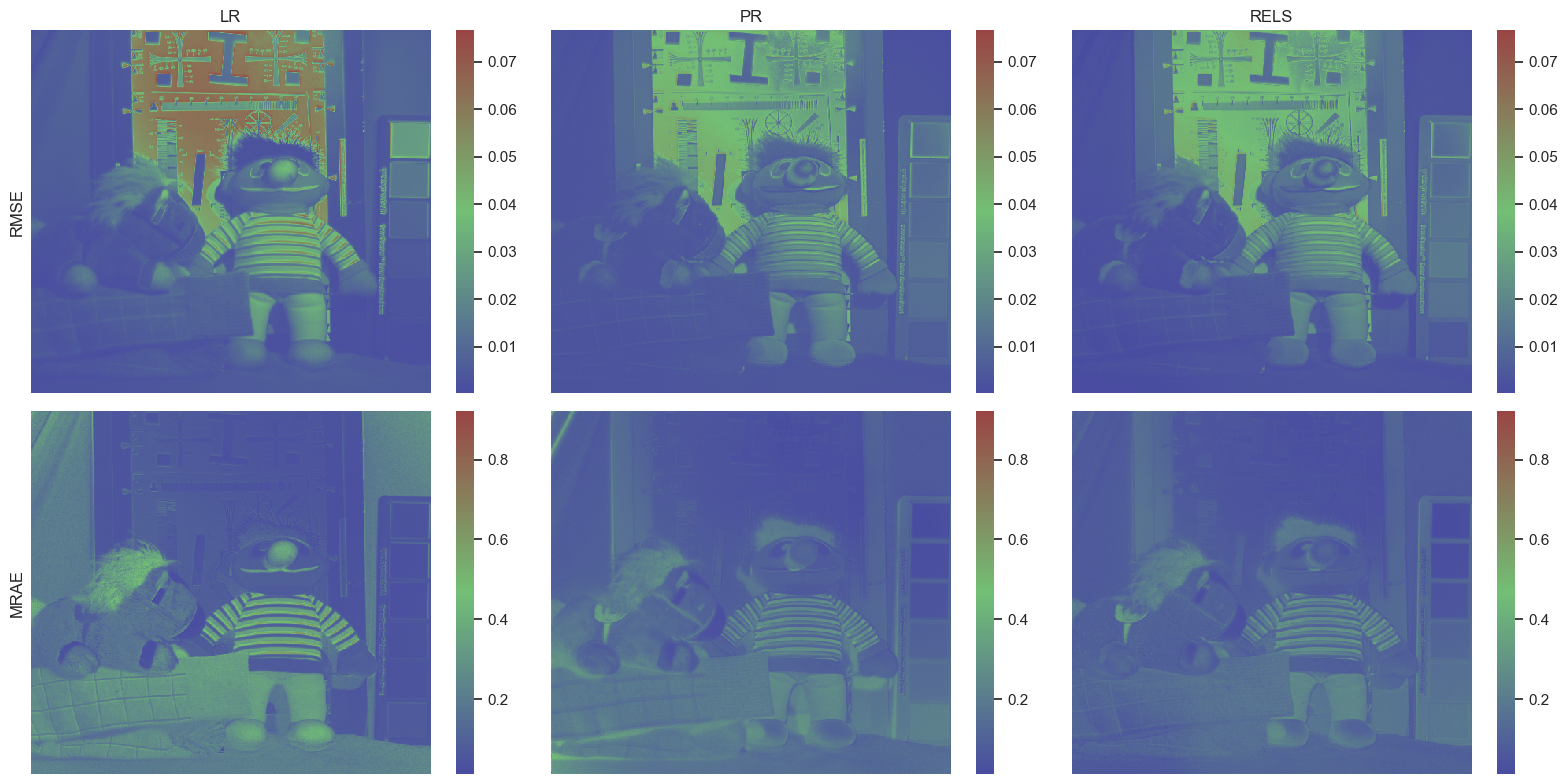

In [21]:
_, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))

sns.heatmap(rmse_lr, cmap=cmap, ax=axes[0, 0], vmin=rmse_vmin, vmax=rmse_vmax)
axes[0, 0].set_title('LR')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].set_xticks([])
axes[0, 0].set_yticks([])

sns.heatmap(mrae_lr, cmap=cmap, ax=axes[1, 0], vmin=mrae_vmin, vmax=mrae_vmax)
axes[1, 0].set_ylabel('MRAE')
axes[1, 0].set_xticks([])
axes[1, 0].set_yticks([])

sns.heatmap(rmse_pr, cmap=cmap, ax=axes[0, 1], vmin=rmse_vmin, vmax=rmse_vmax)
axes[0, 1].set_title('PR')
axes[0, 1].set_xticks([])
axes[0, 1].set_yticks([])

sns.heatmap(mrae_pr, cmap=cmap, ax=axes[1, 1], vmin=mrae_vmin, vmax=mrae_vmax)
axes[1, 1].set_xticks([])
axes[1, 1].set_yticks([])

sns.heatmap(rmse_rels, cmap=cmap, ax=axes[0, 2], vmin=rmse_vmin, vmax=rmse_vmax)
axes[0, 2].set_title('RELS')
axes[0, 2].set_xticks([])
axes[0, 2].set_yticks([])

sns.heatmap(mrae_rels, cmap=cmap, ax=axes[1, 2], vmin=mrae_vmin, vmax=mrae_vmax)
axes[1, 2].set_xticks([])
axes[1, 2].set_yticks([])

plt.tight_layout()
plt.show()

## Principal Component Analysis

In [22]:
n_components = 4

In [23]:
X_test, y_test = load_dataset(images_test)

In [24]:
X_test_poly = PolynomialFeatures(degree=6, include_bias=False).fit_transform(X_test)

In [25]:
pca_test = PCA(n_components).fit(y_test)

In [26]:
y_pred_lr = model_lr.predict(X_test)
pca_pred_lr = PCA(n_components).fit(y_pred_lr)

In [27]:
y_pred_pr = model_pr.predict(X_test)
pca_pred_pr = PCA(n_components).fit(y_pred_pr)

In [28]:
y_pred_rels = model_rels.predict(X_test_poly)
pca_pred_rels = PCA(n_components).fit(y_pred_rels)

In [29]:
pd.DataFrame(np.vstack((
    pca_test.explained_variance_ratio_,
    pca_pred_lr.explained_variance_ratio_,
    pca_pred_pr.explained_variance_ratio_,
    pca_pred_rels.explained_variance_ratio_,
)), index=['GT', 'LR', 'PR', 'RELS'])

,0,1,2,3
GT,0.935904,0.047264,0.011054,2.644080e-03
LR,0.942061,0.046442,0.011497,4.208192e-16
PR,0.936959,0.046844,0.013315,1.222514e-03
RELS,0.936750,0.047450,0.012640,1.311704e-03


93.59\cdot10^-2	4.73\cdot10^-2	1.11\cdot10^-2	2.644\cdot10^-3
94.21\cdot10^-2	4.64\cdot10^-2	1.15\cdot10^-2	4.21\cdot10^-16
93.70\cdot10^-2	4.68\cdot10^-2	1.33\cdot10^-2	1.22\cdot10^-3
93.68\cdot10^-2	4.69\cdot10^-2	1.30\cdot10^-2	1.45\cdot10^-3

In [30]:
for k in range(n_components):
    if np.dot(pca_test.components_[k], pca_pred_lr.components_[k]) < 0:
        pca_pred_lr.components_[k] *= -1

    if np.dot(pca_test.components_[k], pca_pred_pr.components_[k]) < 0:
        pca_pred_pr.components_[k] *= -1

    if np.dot(pca_test.components_[k], pca_pred_rels.components_[k]) < 0:
        pca_pred_rels.components_[k] *= -1

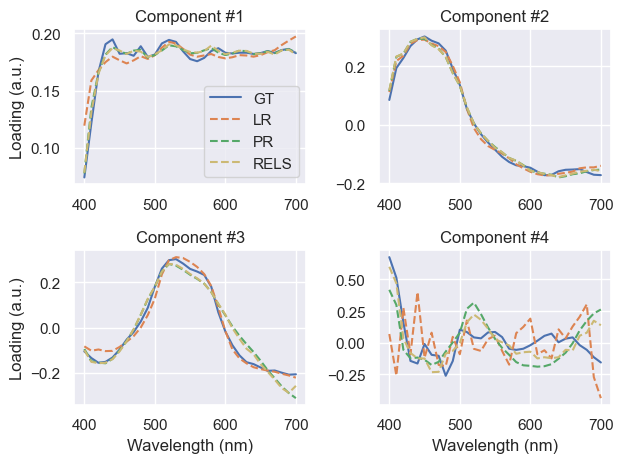

In [31]:
_, axes = plt.subplots(nrows=2, ncols=2)

axes[0, 0].set_title(f'Component #1')
axes[0, 0].plot(bands, pca_test.components_[0], label='GT')
axes[0, 0].plot(bands, pca_pred_lr.components_[0], linestyle='--', label='LR')
axes[0, 0].plot(bands, pca_pred_pr.components_[0], linestyle='--', label='PR')
axes[0, 0].plot(bands, pca_pred_rels.components_[0], linestyle='--', label='RELS', color='y')
axes[0, 0].set_ylabel('Loading (a.u.)')
axes[0, 0].legend()

axes[0, 1].set_title(f'Component #2')
axes[0, 1].plot(bands, pca_test.components_[1], label='GT')
axes[0, 1].plot(bands, pca_pred_lr.components_[1], linestyle='--', label='LR')
axes[0, 1].plot(bands, pca_pred_pr.components_[1], linestyle='--', label='PR')
axes[0, 1].plot(bands, pca_pred_rels.components_[1], linestyle='--', label='RELS', color='y')

axes[1, 0].set_title(f'Component #3')
axes[1, 0].plot(bands, pca_test.components_[2], label='GT')
axes[1, 0].plot(bands, pca_pred_lr.components_[2], linestyle='--', label='LR')
axes[1, 0].plot(bands, pca_pred_pr.components_[2], linestyle='--', label='PR')
axes[1, 0].plot(bands, pca_pred_rels.components_[2], linestyle='--', label='RELS', color='y')
axes[1, 0].set_xlabel('Wavelength (nm)')
axes[1, 0].set_ylabel('Loading (a.u.)')

axes[1, 1].set_title(f'Component #4')
axes[1, 1].plot(bands, pca_test.components_[3], label='GT')
axes[1, 1].plot(bands, pca_pred_lr.components_[3], linestyle='--', label='LR')
axes[1, 1].plot(bands, pca_pred_pr.components_[3], linestyle='--', label='PR')
axes[1, 1].plot(bands, pca_pred_rels.components_[3], linestyle='--', label='RELS', color='y')
axes[1, 1].set_xlabel('Wavelength (nm)')

plt.tight_layout()
plt.show()